#### Thoughts

The difference in this competition is that, train contains feature but test contains only ID. 
- For non-time-based features (e.g. features from item name), some kind of mapping has to be created. 
- For time-based features, we should create lagged features on the entire labeled data available <strong> INCLUSIVE of the validation data </strong>, then train on train portion and and test on the validation portion.

#### Next step - set up a flexible training and validation process.
1. Time-based split of train & val - easy to change cut-off date
2. Train on train, val on val, and then train on the entire (train+val) and apply to test (to get submission to LB)
3. Easy to add time-based features (i.e. more lags)

##### And first baby-step of that...
1. Replicate previous_value_benchmark model
2. Add in one-hot month (non-time based) to capture seanality and see how much improvement we get
    - Other non-time features: similarity features from names?
3. Add in a couple lag1 features (time-based) to see how much improvement we get
    - by shop-item          
    - by shop
    - by item
    
#### Also keep in mind: Almost half of the shop-item combos in test are unseen in train, how to improve this?
    - Train a separate model on unseen?



In [1]:
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [3]:
from itertools import product # to expand month-shop-item combo

In [4]:
import pickle

In [5]:
import gc
import warnings
warnings.filterwarnings('ignore')

In [6]:
from tqdm import tqdm_notebook

In [7]:
def rmse_clip(y_true, y_pred):
    y_pred = y_pred.clip(0,20)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return(rmse)

In [8]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

### Read in Data

In [ ]:
train = pd.read_csv(r'../data/sales_train.csv.gz')
train.shape

In [ ]:
train[:3]

#### Check what is in other data

In [ ]:
items0 = pd.read_csv(r'../data/items.csv')
# shops0 = pd.read_csv(r'../data/shops.csv')
# item_cat0 = pd.read_csv(r'../data/item_categories.csv')
items0[:3] # ok contains name of the item/cat/shop; ABBYY FineReader??

In [ ]:
train[(train.shop_id==25)&(train.item_id==2552)]  
# looks like return. looks like negative rows should be removed
# Or make a "returned?" feature

In [ ]:
(train['item_cnt_day']==0).sum()

In [ ]:
train2 = train[train.item_cnt_day>0]
# train2 = train[(train.item_cnt_day>0) & train.shop_id.isin(test.shop_id.unique())]

print(train2.shape)

train2['date2'] = pd.to_datetime(train2['date'],format='%d.%m.%Y')
train2.drop(labels='date',axis=1,inplace=True)

# print(train2.shop_id.nunique())
# pickle.dump(train2,open(r'../data2/train_42shops.pkl','wb'))
del train

### Aggregate sale by month
#### Aggregate on the original data

In [ ]:
train2 = pd.merge(train2, items0[['item_id','item_category_id']],how='left')
train2[:3]

In [ ]:
# monthly sales by shop-item
train2.sort_values(by=['date_block_num','shop_id','item_category_id','item_id','date2'],inplace=True)
monthly_sales = train2.groupby(['date_block_num','item_category_id','shop_id','item_id'],as_index=False)\
    .agg({'item_cnt_day':{'shop_item_cnt':'sum'}})

monthly_sales.columns = [col[0] if col[-1]=='' else col[-1] for col in monthly_sales.columns.values]

# monthly sales by shop
temp = train2.groupby(['date_block_num','shop_id'],as_index=False).agg({'item_cnt_day':{'shop_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

monthly_sales=pd.merge(monthly_sales,temp,how='left',on=['date_block_num','shop_id']).fillna(0)

# monthly sales by cat
temp = train2.groupby(['date_block_num','item_category_id'],as_index=False).agg({'item_cnt_day':{'cat_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
temp[:3]
monthly_sales=pd.merge(monthly_sales,temp,how='left',on=['date_block_num','item_category_id']).fillna(0)

# monthly sales by item
temp = train2.groupby(['date_block_num','item_id'],as_index=False).agg({'item_cnt_day':{'item_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

monthly_sales=pd.merge(monthly_sales,temp,how='left',on=['date_block_num','item_id']).fillna(0)

# downcast types to save memory
monthly_sales=downcast_dtypes(monthly_sales)
monthly_sales[:3]

In [ ]:
del train2

#### Expand the month/shop/item grid

In [ ]:
shops_in_tr = monthly_sales.shop_id.unique()
items_in_tr = monthly_sales.item_id.unique()
months_in_tr = monthly_sales.date_block_num.unique()
print(len(shops_in_tr),len(items_in_tr),len(months_in_tr))

grid = np.array(list(product(*[shops_in_tr,items_in_tr,months_in_tr])),dtype='int32')

grid = pd.DataFrame(grid,columns=['shop_id','item_id','date_block_num'],dtype='int32')

In [ ]:
monthly_sales_all = pd.merge(grid,monthly_sales,on=['shop_id','item_id','date_block_num'],how='left').fillna(0)
print(monthly_sales_all.shape)
monthly_sales_all[:3]

In [ ]:
del grid

### Start building features

#### Set up time-based features

In [ ]:
# Clear seasonality - spike in Dec; March
# Also a clear downward sloping trend
plt.figure(figsize=(20,5))
monthly_sales_all.groupby(['date_block_num'])['shop_item_cnt'].sum().plot() 

In [ ]:
monthly_sales['shop_item_cnt'].describe()  # max is 2000!

In [ ]:
np.percentile(monthly_sales['shop_item_cnt'],99.5)

<strong>Since we have lag features, we are just going to build the features on entire monthly_sales data w/o spliting monthly_sales and X_val. 
    
However, make sure we do feature selection only on the monthly_sales portion (where date_block_num < hold_out_month) </strong>

In [ ]:
index_cols = ['shop_id','item_id','item_category_id','date_block_num']
cols_to_rename = list(monthly_sales_all.columns.difference(index_cols)) # all columns except these three
shift_range = [1,2,3,4,5,12]
cols_to_rename

In [ ]:
for month_shift in tqdm_notebook(shift_range):
    
    """Take the entire data set, add 1 to date_block_num, and rename the columns that we want to create a lag for"""
    
    train_shift = monthly_sales_all[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    monthly_sales_all = pd.merge(monthly_sales_all, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

In [ ]:
print(monthly_sales_all.shape)
monthly_sales_all[:3]

In [ ]:
# # List of all lagged features
# fit_cols = [col for col in monthly_sales_all.columns if col[-1] in [str(item) for item in shift_range]] 
# # We will drop these at fitting stage
# to_drop_cols = list(set(list(monthly_sales_all.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
# to_drop_cols

- <strong>One-hot encode month</strong>

In [ ]:
enc = OneHotEncoder()

In [ ]:
m_onehot = enc.fit_transform(pd.Series(list(range(1,13))).reshape(-1,1)).toarray()
m_onehot.shape
# 12 levels -> 12 features, need to drop 1 to avoid multicolinearity (since we are first going to fit a linear model)

# reshape(-1,1) -1 means unknown dimension which we just let numpy to figure out
# since OneHotEncoder() takes 2-D array, we need to make our 1D series into a 2-D matrix format
# we know there is one column, and let numpy to figure out how many rows there should be
# <=> reshape.(rows_in_your_data,1)

In [ ]:
m_onehot_df = pd.DataFrame(np.hstack((np.array(range(1,13)).reshape(12,1),m_onehot[:,1:])), columns=['month']+['m'+str(i) for i in range(2,13)], dtype='int32')
m_onehot_df

In [ ]:
monthly_sales_all['month'] = (np.mod(monthly_sales_all.date_block_num,12)+1).astype('int32')

In [ ]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month').drop(labels=['month'],axis=1)
monthly_sales_all[:3]

In [ ]:
monthly_sales_all = downcast_dtypes(monthly_sales_all)
monthly_sales_all.dtypes

In [ ]:
%%time
monthly_sales_all.to_hdf(r'../data2/monthly_sales_all_shop_item_w_lag_onehot_m.h5','monthly_sales_all')

In [9]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_sales_all_shop_item_w_lag_onehot_m.h5','monthly_sales_all')

Wall time: 9.38 s


#### Predict w lag v RF w lag

In [10]:
hold_out_month = 33
val_month = 32

In [11]:
feats = ['shop_item_cnt_lag_1']

In [12]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,shop_item_cnt_lag_1
32,25,16257,0.0,0.0
66,25,5606,0.0,0.0
100,25,5572,0.0,0.0


#### Benchmark - on val and hold-out

In [13]:
print('Hold out BC (month 33):')
print(rmse_clip(y_true = hold_out_df.loc[hold_out_df.shop_item_cnt>0,'shop_item_cnt'],y_pred = hold_out_df.loc[hold_out_df.shop_item_cnt>0,'shop_item_cnt_lag_1']))

Hold out BC (month 33):
14.38222156410965


In [14]:
print('Val BC (month 32)')
print(rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = val.loc[val.shop_item_cnt>0,'shop_item_cnt_lag_1']))

Val BC (month 32)
18.07412546239703


#### Model

In [16]:
feats = ['shop_item_cnt_lag_1',  'item_cnt_lag_1',  'shop_cnt_lag_1', 'cat_cnt_lag_1',
         'shop_item_cnt_lag_2',  'item_cnt_lag_2',  'shop_cnt_lag_2', 'cat_cnt_lag_2',
         'shop_item_cnt_lag_3',  'item_cnt_lag_3',  'shop_cnt_lag_3', 'cat_cnt_lag_3',
         'shop_item_cnt_lag_4',  'item_cnt_lag_4',  'shop_cnt_lag_4', 'cat_cnt_lag_4',
         'shop_item_cnt_lag_5',  'item_cnt_lag_5',  'shop_cnt_lag_5', 'cat_cnt_lag_5',
         'shop_item_cnt_lag_12', 'item_cnt_lag_12', 'shop_cnt_lag_12','cat_cnt_lag_12',
         'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'
        ]

In [17]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,shop_item_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,cat_cnt_lag_1,shop_item_cnt_lag_2,item_cnt_lag_2,shop_cnt_lag_2,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
32,25,16257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
66,25,5606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
100,25,5572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [18]:
gc.collect()

131

In [19]:
# Not using the first 12 month
X_train = monthly_sales_all.loc[(monthly_sales_all.date_block_num>=12) &(monthly_sales_all.date_block_num<val_month),feats]
y_train = monthly_sales_all.loc[(monthly_sales_all.date_block_num>=12) &(monthly_sales_all.date_block_num<val_month),'shop_item_cnt']

In [20]:
del monthly_sales_all
gc.collect()

51

In [21]:
%%time
corr = X_train.corr()

Wall time: 1min 23s


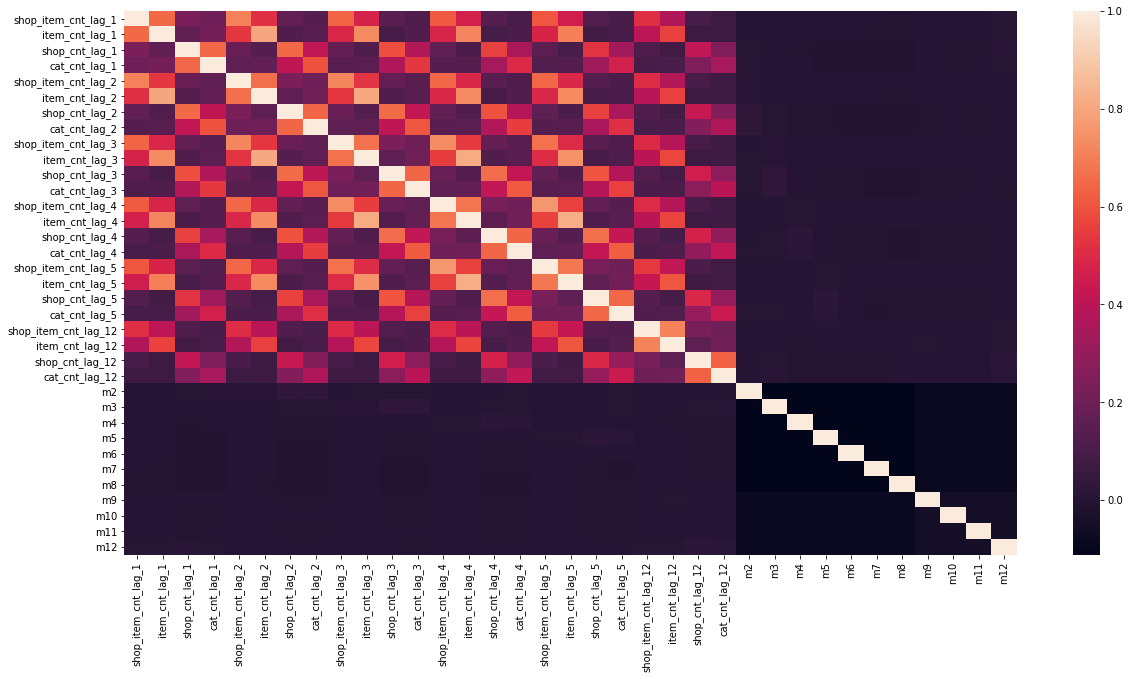

In [22]:
plt.figure(figsize=(20,10))
sns.heatmap(corr)

In [23]:
lm = LinearRegression()

In [24]:
gc.collect()

75

In [25]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
pred_lm = lm.predict(val[feats])

In [30]:
rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = pred_lm[val.shop_item_cnt>0])

18.17282228196122

In [31]:
gc.collect()

210

In [32]:
%%time
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

Wall time: 4min 16s


In [35]:
pred_lgb = model.predict(val[feats])
print("Val (32):",rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = pred_lgb[val.shop_item_cnt>0]))

Val (32): 18.079757853909115


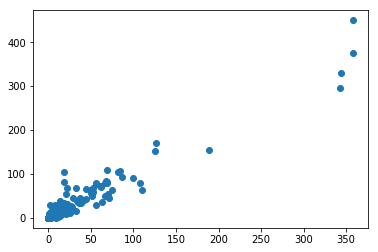

In [36]:
plt.scatter(pred_lgb[val.shop_item_cnt>0],pred_lm[val.shop_item_cnt>0])

([<matplotlib.axis.XTick at 0x201006dbb00>,
 <a list of 35 Text xticklabel objects>)

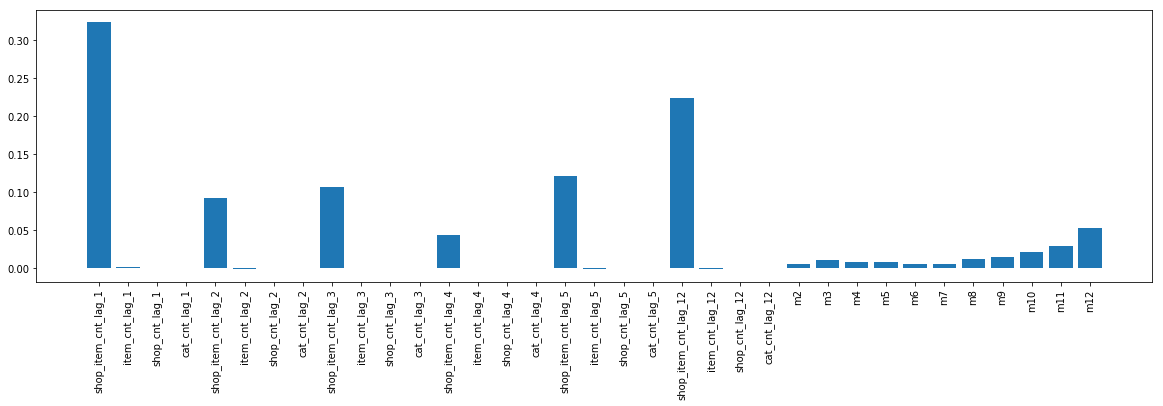

In [37]:
plt.figure(figsize=(20,5))
ticks = list(range(len(lm.coef_)))
plt.bar(ticks,height=lm.coef_)
plt.xticks(ticks,feats,rotation=90)

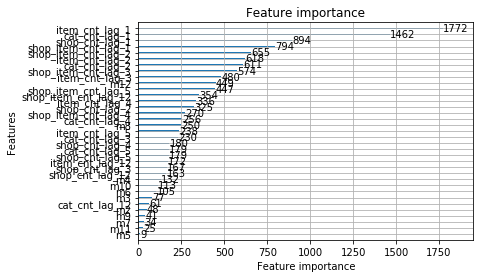

In [38]:
lgb.plot_importance(model)

### Ok, why doesn't score improve???

In [39]:
val['lm_pred'] = pred_lm
val['lgb_pred'] = pred_lgb
val2 = val[val.shop_item_cnt>0]
val2.shape

(29652, 40)

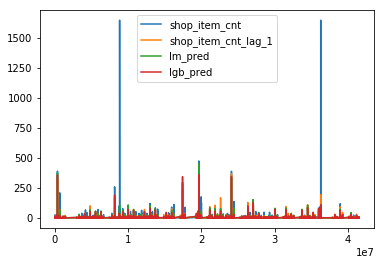

In [40]:
plt.figure(figsize=(20,5))
val2[['shop_item_cnt','shop_item_cnt_lag_1','lm_pred','lgb_pred']].plot()

## Ok there seems to be Extremely high sales of in month 32

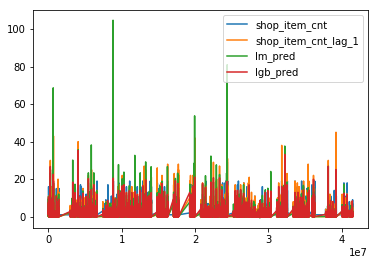

In [41]:
val2.loc[val2.shop_item_cnt<20,['shop_item_cnt','shop_item_cnt_lag_1','lm_pred','lgb_pred']].plot()

In [42]:
# Not too bad for the normal range... 
# Stacking will work
for col in ['shop_item_cnt_lag_1','lm_pred','lgb_pred']:
    print(col,rmse_clip(val2.loc[val2.shop_item_cnt<20,'shop_item_cnt'],val2.loc[val2.shop_item_cnt<20,col]))

shop_item_cnt_lag_1 2.2048763591676313
lm_pred 2.0592795500643613
lgb_pred 1.875999599980428


### Create a new submission

In [ ]:
test = pd.read_csv(r'../data/test.csv.gz')
test[:3]

In [ ]:
def generate_lags_for_test(data,old_var_name,new_var_pre,n_lags):
    
    # make sure it's properly sorted
    data.sort_values(by=['shop_id','item_id'],inplace=True)
    
    months = [33 - n for n in range(n_lags)]
    dfs=[]
    for m in months:
        df = data.loc[data.date_block_num == m, old_var_name].reset_index(drop=True)
        dfs.append(df)
        
    all_feats = pd.concat(dfs,axis=1,ignore_index=True)
    all_feats.columns = [new_var_pre + str(n+1) for n in range(n_lags)]
    
    return(pd.concat([data.loc[data.date_block_num == months[0],['shop_id','item_id']].reset_index(drop=True), all_feats], axis=1))

In [ ]:
test_lags = generate_lags_for_test(all_feat,'item_cnt_month','sh_it_cnt_lg',2)
print(test_lags.shape)
test_lags[:3]

In [ ]:
test_m_onehot = np.zeros((len(test),11))
test_m_onehot[:,9] = 1
test_m_onehot = pd.DataFrame(test_m_onehot, columns=["m"+str(i) for i in range(2,13)])
test_m_onehot[:3]

In [ ]:
test_feats = pd.merge(test,test_lags,how='left',on=['shop_id','item_id'])
test_feats = pd.concat([test_feats,test_m_onehot],axis=1)
print(test_feats.shape)
test_feats[:3]

In [ ]:
# test_feats.loc[(test_feats.sh_it_cnt_lg1==0) & (test_feats.sh_it_cnt_lg2==0),['sh_it_cnt_lg1','sh_it_cnt_lg2']] = np.nan
test_feats.loc[(test_feats.sh_it_cnt_lg1==0),['sh_it_cnt_lg1','sh_it_cnt_lg2']] = np.nan

In [ ]:
print(test_feats.sh_it_cnt_lg1.isnull().sum())

# test_feats.fillna(0,inplace=True)
# Fill NA w 0 first and then predict performs significantly worse 
# than predict only on non-NAs and then fill the rest of unpredicted with 0

In [ ]:
## Train a new model inclusive of October data
X_tr_all = all_feat.loc[(all_feat.date_block_num>=n_lags) & (all_feat.item_cnt_month>0),
                    ['sh_it_cnt_lg1','sh_it_cnt_lg2','item_cnt_month']+['m'+str(i) for i in range(2,13)]]
print(X_tr_all.shape)

In [ ]:
lm_tr_all = LinearRegression()
lm_tr_all.fit(X_tr_all.drop(labels='item_cnt_month',axis=1),X_tr_all.item_cnt_month)

In [ ]:
lm_tr.coef_

In [ ]:
lm_tr_all.coef_

In [ ]:
test_model = test_feats[test_feats.sh_it_cnt_lg1.notnull()]

## Here the modeled trained on 0-32 and validated on 33 was used;
## Performed worse than predict w previous month value => model clearly overfits
# test_model['item_cnt_month'] = lm_tr.predict(test_model.drop(labels=['ID','shop_id','item_id'],axis=1)).clip(0,20)

## Retrain the model with the same features on 0-33
test_model['item_cnt_month'] = lm_tr_all.predict(test_model.drop(labels=['ID','shop_id','item_id'],axis=1)).clip(0,20)
test_na = test_feats[test_feats.sh_it_cnt_lg1.isnull()]
test_na['item_cnt_month'] = 0

In [ ]:
test_model[:3]

In [ ]:
# test['item_cnt_month'] = lm.predict(test_feats.drop(labels=['ID','shop_id','item_id'],axis=1))
# test['item_cnt_month'] = test['item_cnt_month'].clip(0,20)
test_model['item_cnt_month'].describe()

In [ ]:
pd.concat([test_model[['ID','item_cnt_month']],test_na[['ID','item_cnt_month']]])\
           .to_csv(r'../output/9_1004_lm_2lg_onehot m_v4.csv',index=False)